## CNN binary classifier to identify whether two adjacent voxel belong to the same type of neuron
### features: (1) 2d larger patch as input. (2) rotating the raw volume to consider 6 different directions.

In [1]:
import scipy.io as sio
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
overallRawVolume = sio.loadmat('../Sample_Datasets/Training/overallRawVolume.mat')['overallRawVolume'].astype(np.float)
#shape=(200, 200, 100, 4), value range=(0,1)

In [5]:
volumeLabels = sio.loadmat('../Sample_Datasets/Training/volumeLabels.mat')['volumeLabels']
#shape=(1, 9), each entry is an array with shape=(200, 200, 100)

In [36]:
def process_volumeLabels(VolumeLabels):
    '''
        Input: VolumeLabels -- 2D array of shape=(1, num_neuron_types), E.g.: volumeLabels. Each entry of VolumeLabels[0,i]
                               is an 0-1 array with shape=(200, 200, 100) indicating if the voxel is labeled neuron i.
        Output: new_VolumeLabels -- 4D array of shape=(num_neuron_types,image_length,image_width,image_height).
        This function reshapes the raw volumeLabels to a more readable format.
    '''
    num_type = VolumeLabels.shape[1] #>>9
    L, W, H = VolumeLabels[0,0].shape #>>(200,200,100)
    new_VolumeLabels = np.zeros([num_type, L, W, H],dtype=np.int)
    for neuron_type in range(num_type):
        new_VolumeLabels[neuron_type,:,:,:] = VolumeLabels[0,neuron_type]
    assert(new_VolumeLabels.dtype == np.int)    
    return new_VolumeLabels

In [37]:
new_VolumeLabels = process_volumeLabels(volumeLabels) #shape=(9,200,200,100)

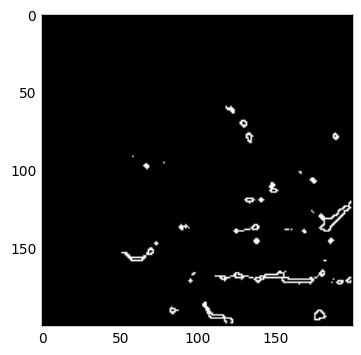

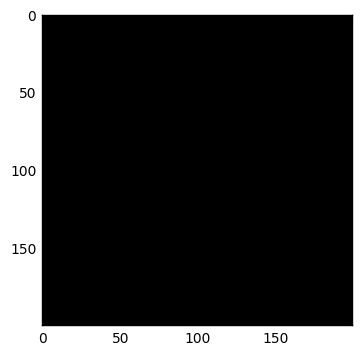

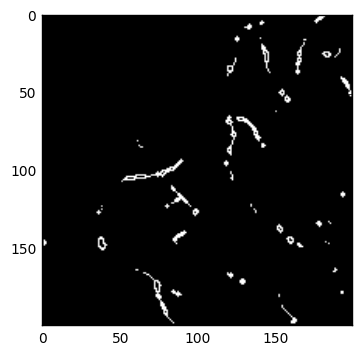

In [16]:
#image samples of VolumeLabels
image1 = new_VolumeLabels[2,:,:,50]
plt.imshow(image1,cmap='gray')
plt.show()
image2 = new_VolumeLabels[4,:,:,50]
plt.imshow(image2,cmap='gray')
plt.show()
image3 = new_VolumeLabels[6,:,:,50]
plt.imshow(image3,cmap='gray')
plt.show()

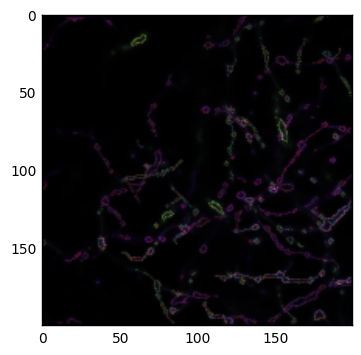

In [17]:
#image sample of overallRawVolume
image4 = overallRawVolume[:,:,50,:3]
plt.imshow(image4,cmap='gray')
plt.show()

In [30]:
def one_one_case_coor(label_3D_image):
    '''
        Input: label_3D_image -- 3D array of shape=(num_neuron_types,length,width),
                                 label array for one slice of raw volume. E.g., new_VolumeLabels[:,:,:,50]
        Output: one_one_coor -- list. Each entry is a 2d coordinate of [1,1] (meaning two adjacent 
                                neurons belong to the same type) case.
        The function finds out all coordinate of [1,1] case given a label array for one slice of raw volume.
    '''
    num_type, L, W = label_3D_image.shape
    one_one_coor = []
    for neuron_type in range(num_type):
        label_one_xcoor, label_one_ycoor = np.where( label_3D_image[neuron_type,:,:] == 1 )
        label_one_coor = zip(label_one_xcoor.tolist(), label_one_ycoor.tolist())
        for x,y in label_one_coor:
            if (y < W-1) and (label_3D_image[neuron_type, x, y] == label_3D_image[neuron_type, x, y+1]) \
            and ((x,y) not in one_one_coor):
                one_one_coor.append((x,y))
                assert(label_3D_image[neuron_type, x, y] == 1)
    
    return one_one_coor

In [31]:
one_one_coor = one_one_case_coor(new_VolumeLabels[:,:,:,50])
print(len(one_one_coor))

1823


In [32]:
def one_zero_case_coor(label_3D_image, one_one_coor):
    '''
        Inputs: label_3D_image -- 3D array of shape=(num_neuron_types,length,width),
                                  label array for one slice of raw volume. E.g., new_VolumeLabels[:,:,:,50]
                one_one_coor -- list. Each entry is a 2d coordinate of [1,1] (meaning two adjacent 
                                neurons belong to the same type) case.
        Output: one_zero_coor -- list. Each entry is a 2d coordinate of [1,0] (meaning two adjacent 
                                neurons belong to different type or the left voxel is a neuron while 
                                the right one is a background) case.
        This function finds out all coordinate of [1,0] case given a label array for one slice of raw volume.
    '''
    num_type, L, W = label_3D_image.shape
    one_zero_coor = []
    for neuron_type in range(num_type):
        label_one_xcoor, label_one_ycoor = np.where( label_3D_image[neuron_type,:,:] == 1 )
        label_one_coor = zip(label_one_xcoor.tolist(), label_one_ycoor.tolist())
        for x,y in label_one_coor:
            if (y < W-1) and (label_3D_image[neuron_type, x, y+1] == 0) \
            and ((x,y) not in one_zero_coor) and ((x,y) not in one_one_coor):
                one_zero_coor.append((x,y))
                assert(label_3D_image[neuron_type, x, y] == 1 and label_3D_image[neuron_type, x, y+1] == 0)
        
    return one_zero_coor

In [33]:
one_zero_coor = one_zero_case_coor(new_VolumeLabels[:,:,:,50], one_one_coor)
print(len(one_zero_coor))

1325


In [34]:
def zero_one_case_coor(label_3D_image, one_one_coor, one_zero_coor):
    '''
        Inputs: label_3D_image -- 3D array of shape=(num_neuron_types,length,width),
                                  label array for one slice of raw volume. E.g., new_VolumeLabels[:,:,:,50]
                one_one_coor -- list. Each entry is a 2d coordinate of [1,1] (meaning two adjacent 
                                neurons belong to the same type) case.
                one_zero_coor -- list. Each entry is a 2d coordinate of [1,0] (meaning two adjacent 
                                neurons belong to different type or the left voxel is a neuron while 
                                the right one is a background) case.                
        Output: zero_one_coor -- list. Each entry is a 2d coordinate of [0,1] (meaning two adjacent 
                                neurons belong to different type or the left voxel is a background while 
                                the right one is a neuron) case.
        This function finds out all coordinate of [0,1] case given a label array for one slice of raw volume.
    '''
    num_type, L, W = label_3D_image.shape
    zero_one_coor = []
    coor_union = one_one_coor + one_zero_coor
    for neuron_type in range(num_type):
        label_one_xcoor, label_one_ycoor = np.where( label_3D_image[neuron_type,:,:] == 1 )
        label_one_coor = zip(label_one_xcoor.tolist(), label_one_ycoor.tolist())
        for x,y in label_one_coor:
            if (y < W-1) and (y > 0) and (label_3D_image[neuron_type, x, y-1] == 0) \
                and ((x,y-1) not in coor_union) \
                and ((x,y-1) not in zero_one_coor):
                zero_one_coor.append((x,y-1))
                assert(label_3D_image[neuron_type, x, y]==1 and label_3D_image[neuron_type, x, y-1]==0)
        
    return zero_one_coor

In [35]:
zero_one_coor = zero_one_case_coor(new_VolumeLabels[:,:,:,50], one_one_coor, one_zero_coor)
print(len(zero_one_coor))

1280


In [38]:
def zero_zero_case_coor(label_3D_image, one_one_coor, one_zero_coor, zero_one_coor):
    '''
        Inputs: label_3D_image -- 3D array of shape=(num_neuron_types,length,width),
                                  label array for one slice of raw volume. E.g., new_VolumeLabels[:,:,:,50]
                one_one_coor -- list. Each entry is a 2d coordinate of [1,1] (meaning two adjacent 
                                neurons belong to the same type) case.
                one_zero_coor -- list. Each entry is a 2d coordinate of [1,0] (meaning two adjacent 
                                neurons belong to different type or the left voxel is a neuron while 
                                the right one is a background) case.
                zero_one_coor -- list. Each entry is a 2d coordinate of [0,1] (meaning two adjacent 
                                neurons belong to different type or the left voxel is a background while 
                                the right one is a neuron) case.
        Output: zero_zero_coor -- list. Each entry is a 2d coordinate of [0,0] (meaning two adjacent 
                                  neurons are both background) case.
        This function finds out all coordinate of [0,0] case given a label array for one slice of raw volume.
    '''
    from itertools import product
    num_type, L, W = label_3D_image.shape
    coor_union = one_one_coor + one_zero_coor + zero_one_coor
    all_coor = list(product(range(L), range(W-1)))
    zero_zero_case = [item for item in all_coor if item not in coor_union]
    
    return zero_zero_case

In [39]:
zero_zero_coor = zero_zero_case_coor(new_VolumeLabels[:,:,:,50], one_one_coor, one_zero_coor, zero_one_coor)
print(len(zero_zero_coor))

35372


In [40]:
def four_cases_coor(label_4D_image):
    '''
        Input: label_4D_image -- 4D array of shape=(num_neuron_types,length,width,height)
                                 label array for the whole raw volume. E.g., new_VolumeLabels.
        outputs: one_one -- list. Each entry is a 3d coordinate of a voxel which belongs to [1,1] case.
                one_zero -- list. Each entry is a 3d coordinate of a voxel which belongs to [1,0] case.
                zero_one -- list. Each entry is a 3d coordinate of a voxel which belongs to [0,1] case.
                zero_zero -- list. Each entry is a 3d coordinate of a voxel which belongs to [0,0] case.
        This function divides voxels of a volume into 4 cases (i.e., [1,1], [1,0], [0,1], [0,0])
        and stores the coordinates in the corresponding list.
    '''
    one_one = []
    one_zero = []
    zero_one = []
    zero_zero = []
    _, L, W, H = label_4D_image.shape
    for z in range(H):
        one_one_coor = one_one_case_coor(label_4D_image[:,:,:,z])
        num_one_one = len(one_one_coor)
        one_one += list(zip(one_one_coor, [z]*num_one_one))
        
        one_zero_coor = one_zero_case_coor(label_4D_image[:,:,:,z], one_one_coor)
        num_one_zero = len(one_zero_coor)
        one_zero += list(zip(one_zero_coor, [z]*num_one_zero))
        
        zero_one_coor = zero_one_case_coor(label_4D_image[:,:,:,z], one_one_coor, one_zero_coor)
        num_zero_one = len(zero_one_coor)
        zero_one += list(zip(zero_one_coor, [z]*num_zero_one))
        
        zero_zero_coor = zero_zero_case_coor(label_4D_image[:,:,:,z], one_one_coor, one_zero_coor, zero_one_coor)
        num_zero_zero = len(zero_zero_coor)
        zero_zero += list(zip(zero_zero_coor, [z]*num_zero_zero))
    
    return one_one, one_zero, zero_one, zero_zero

In [41]:
one_one, one_zero, zero_one, zero_zero = four_cases_coor(new_VolumeLabels)

In [42]:
print(len(one_one), len(one_zero), len(zero_one), len(zero_zero))

77000 63816 62409 3776775


In [46]:
def undersampling(coor_list, num_samples):
    '''
        Inputs: coor_list -- list. Each entry is a coordinate.
                num_samples -- integer. Denotes hom many samples user needs after undersampling.
        Output: new_coor_list -- list. Subset of coor_list.
        This function randomly selects num_samples samples from coor_list.
    '''
    num_all_datapoints = len(coor_list)
    samples_index = np.random.randint(0,num_all_datapoints,num_samples).tolist()
    new_coor_list = [coor_list[i] for i in samples_index]
    
    return new_coor_list

In [47]:
def balance_dataset(one_one, one_zero, zero_one, zero_zero):
    '''
        Inputs: one_one, one_zero, zero_one, zero_zero -- Each is a list consists of coordinates
                                                          belong to corresponding case.
        Outputs: one_one -- list. The same as input one_one.
                 balanced_one_zero -- list. Subset of one_zero which has around 1/3 number of samples of one_one.
                 balanced_zero_one -- list. Subset of zero_one which has aroud 1/3 number of samples of one_one.
                 balanced_zero_zero -- list. Subset of zero_zero which has around 1/3 number of samples of one_one.
        This function balances the 4 input datasets by undersampling the other three(one_zero, zero_one, zero_zero).
    '''
    num_one_one = len(one_one)
    num_one_zero_need = num_one_one // 3
    num_zero_one_need = num_one_zero_need
    num_zero_zero_need = num_one_one - num_one_zero_need*2
    balanced_one_zero = undersampling(one_zero, num_one_zero_need)
    balanced_zero_one = undersampling(zero_one, num_zero_one_need)
    balanced_zero_zero = undersampling(zero_zero, num_zero_zero_need)
    
    return one_one, balanced_one_zero, balanced_zero_one, balanced_zero_zero 

In [48]:
balanced_one_one, balanced_one_zero, balanced_zero_one, balanced_zero_zero = balance_dataset(one_one, one_zero, zero_one, zero_zero)

In [50]:
print(len(balanced_one_one), len(balanced_one_zero), len(balanced_zero_one), len(balanced_zero_zero))

77000 25666 25666 25668


In [51]:
def vectorize_y(num_datapoint, label):
    '''
        Inputs: num_datapoint -- integer. Denotes the number of dataponits.
                label -- 0 or 1. Represents the label of a datapoint.
        Output: y -- list. Each entry is a binary encoding.
        This function converts output label (i.e., 0 or 1) into a one-hot vector format.
        0 -> [1,0] and 1 -> [0,1].
    '''
    if label == 1:
        y = [[0,1]] * num_datapoint
    else:
        y = [[1,0]] * num_datapoint
        
    return y

In [81]:
def Y_generator(label_one_coor, label_zero_coor):
    '''
        Input: label_one_coor -- a list consists of coordinates belong to label one case.
               label_zero_coor -- a list consists of coordinates belong to label zero case.
        Output: array of shape = (len(label_one_coor)+len(label_zero_coor), 2)
        This function generate output array Y.
    '''
    Y=[]
    Y += vectorize_y(len(label_one_coor), 1)
    Y += vectorize_y(len(label_zero_coor), 0)
    Y = np.asarray(Y, dtype=np.float)
    
    return Y

In [82]:
label_one_coor = balanced_one_one
label_zero_coor = balanced_one_zero + balanced_zero_one + balanced_zero_zero
Y = Y_generator(label_one_coor, label_zero_coor)

In [99]:
def image_augmentation_each_layer(image_3D, extra_length, zero_padding=True):
    '''
        Inputs: image_3D -- 3d image of shape=(Length, Width, num_Channel), which is sliced from the 4d raw volume.
                extra_length -- integer. Denotes the additional length we need to add to the 'Length' and 'Width'
                                of the image_3D so that the patch size will be [2*extra_length+1, 2*extra_length+1, num_Channel].
                zero_padding -- Boolean (default is True). 'True' means the additional volume is all background (i.e. zero padding).
                                False means the additonal volume will be filled by other techniques.
                                For now, we use 'mirror' technique as default method. Other methods will be
                                added in furture versions.
        Output: new_image_3D -- 3d image of shape=(2*extra_length+Length, 2*extra_length+Width, num_Channel)
        This function use zero padding or 'mirror' padding to augment a 3d image image_3D.
    '''
    L, W, num_channel = image_3D.shape
    new_L = L + 2*extra_length
    new_W = W + 2*extra_length
    new_image_3D = np.zeros([new_L, new_W, num_channel])
    new_image_3D[extra_length:L+extra_length,extra_length:W+extra_length,:] = image_3D
    if zero_padding is False:
        #argument left side:
        new_image_3D[extra_length:L+extra_length,:extra_length,:] = np.fliplr(image_3D)[:,W-extra_length:,:]
        #argument right side:
        new_image_3D[extra_length:L+extra_length,extra_length+W:,:] = np.fliplr(image_3D)[:,:extra_length,:]
        #argument top side:
        new_image_3D[:extra_length,extra_length:W+extra_length,:] = np.flipud(image_3D)[L-extra_length:,:,:]
        #argument bottom side:
        new_image_3D[L+extra_length:,extra_length:W+extra_length,:] = np.flipud(image_3D)[:extra_length,:,:]
    
    return new_image_3D

In [100]:
augmented_image = image_augmentation_each_layer(overallRawVolume[:,:,50,:], 7, True)

In [57]:
def augmented_overallRawVolume(RawVolume, extra_length, zero_padding=True):
    '''
        Inputs: RawVolume -- 4d array of shape=(Length,Width,Height,num_Channel) represents the raw volume.
                extra_length -- integer. Denotes the additional length we need to add to the 'Length' and 'Width'
                                of the slice of the raw volume so that the patch size
                                will be [2*extra_length+1, 2*extra_length+1, num_Channel].
                zero_padding -- Boolean (default is True). 'True' means the additional volume is all background (i.e. zero padding).
                                False means the additonal volume will be filled by other techniques.
                                For now, we use 'mirror' technique as default method. Other methods will be
                                added in furture versions.
        Output: new_RawVolume -- 4d array of shape=(2*extra_length+Length, 2*extra_length+Width, Height, num_Channel)
        This function use zero padding or 'mirror' padding to augment each slice of the raw volume. 
    '''
    L, W, H, num_channel = RawVolume.shape
    new_RawVolume = np.zeros([L+2*extra_length, W+2*extra_length, H, num_channel])
    for layer in range(H):
        new_RawVolume[:,:,layer,:] = image_augmentation_each_layer(RawVolume[:,:,layer,:], extra_length, zero_padding)
    
    return new_RawVolume

In [58]:
new_overallRawVolume = augmented_overallRawVolume(overallRawVolume, 7)

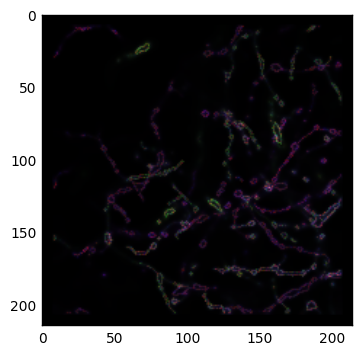

In [59]:
plt.imshow(new_overallRawVolume[:,:,50,:3],cmap='gray')
plt.show()

In [119]:
def X_generator(coor_list, new_RawVolume, extra_length):
    '''
        Inputs: coor_list -- list consists of 3d coordinates of the center voxel of the patch.
                new_RawVolume -- 4d array of shape=(2*extra_length+Length, 2*extra_length+Width, Height, num_Channel).
                extra_length -- integer. Determine how large is the patch size, since
                                patch size = [2*extra_length+1, 2*extra_length+1, num_Channel].
        Output: X -- 3d array. Denotes input dataponts.  
    '''
    X = []
    for ((i,j),k) in coor_list:
        new_i, new_j = (i + extra_length, j + extra_length)
        input_array = new_RawVolume[new_i-extra_length:new_i+1+extra_length,new_j-extra_length:new_j+1+extra_length,k,:]
        X.append(input_array)
    X = np.stack(X, axis=0)
    
    return X

In [120]:
coor_list = balanced_one_one + balanced_one_zero + balanced_zero_one + balanced_zero_zero
X = X_generator(coor_list,new_overallRawVolume, 7)

In [121]:
print(X.shape, Y.shape)

(154000, 15, 15, 4) (154000, 2)


In [95]:
def six_directions_volume_label(RawVolume, VolumeLabel):
    '''
        Inputs: RawVolume -- 4D image array of shape=(Length, Width, Height, num_Channel).
                VolumeLabel -- 4D label array of shape=(num_neuron_types, Length, Width, Height).
        Output: Volume_Label_dict -- dictionary of six (key, value) pair.
                                     'key' name is one of {'y-plus', 'y-minus', 'x-plus',
                                     'x-minus', 'z-plus', 'z-minus'} which denotes the six connections
                                     to which each voxel has the surrounding voxels. (reference: 3D coordinate system)
                                     'value' is a dictionary contains (key,value)=('volume',volume)
                                     and (key,value)=('label',volume_label)
                                              
        This function finds out the corresponding volume and label array of each direction 
        by rotating and interchange two axes of RawVolume and VolumeLabel.         
    '''
    Volume_Label_dict = {'y-plus':{}, 'y-minus':{}, 'x-plus':{}, 'x-minus':{}, 'z-plus':{}, 'z-minus':{}}
    # y-plus direction:
    Volume_Label_dict['y-plus']['volume'] = RawVolume
    Volume_Label_dict['y-plus']['volume_label'] = VolumeLabel
    
    # y-minus direction: rotate an array by 180 degree counterclockwise.
    Volume_Label_dict['y-minus']['volume'] = np.rot90(RawVolume, 2, (0,1))          
    Volume_Label_dict['y-minus']['volume_label'] = np.rot90(VolumeLabel, 2, (1,2))  
    
    #x-plus direction: rotate an array by 90 degree counterclockwise.
    Volume_Label_dict['x-plus']['volume'] = np.rot90(RawVolume, 1, (0,1))           
    Volume_Label_dict['x-plus']['volume_label'] = np.rot90(VolumeLabel, 1, (1,2))   
    
    #x-minus direction: rotate an array by 270 degree counterclockwise.
    Volume_Label_dict['x-minus']['volume'] = np.rot90(RawVolume, 3, (0,1))           
    Volume_Label_dict['x-minus']['volume_label'] = np.rot90(VolumeLabel, 3, (1,2))  
    
    #z-plus direction: interchange two axes of an array and rotate by 270 degree counterclockwise.
    Volume_Label_dict['z-plus']['volume'] = np.rot90(np.swapaxes(RawVolume,0,2), 3, (0,1)) 
    Volume_Label_dict['z-plus']['volume_label'] = np.rot90(np.swapaxes(VolumeLabel,1,3), 3, (1,2))
    
    #z-plus direction: interchange two axes of an array and rotate by 90 degree counterclockwise.
    Volume_Label_dict['z-minus']['volume'] = np.rot90(np.swapaxes(RawVolume,0,2), 1, (0,1)) 
    Volume_Label_dict['z-minus']['volume_label'] = np.rot90(np.swapaxes(VolumeLabel,1,3), 1, (1,2))
    
    return Volume_Label_dict

In [96]:
Volume_Label_dict = six_directions_volume_label(overallRawVolume, new_VolumeLabels)

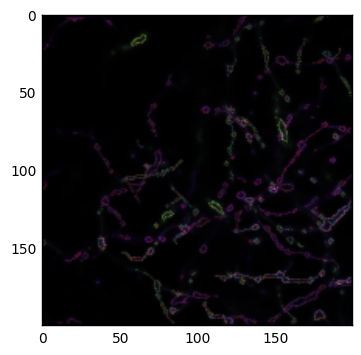

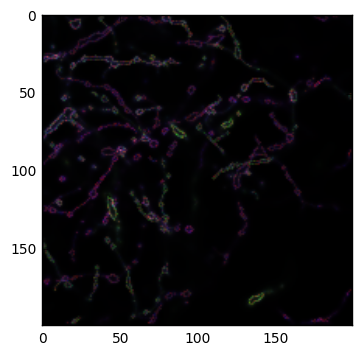

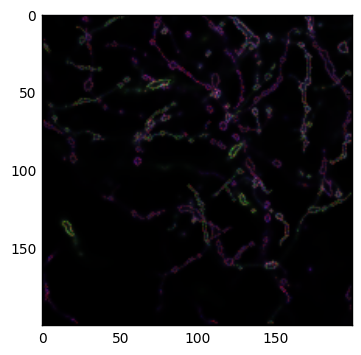

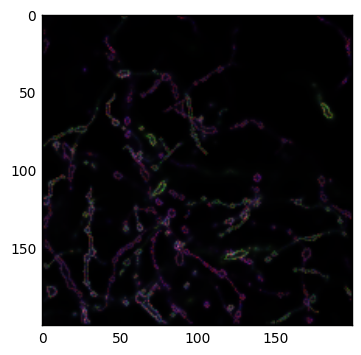

In [97]:
plt.imshow(Volume_Label_dict['y-plus']['volume'][:,:,50,:3],cmap='gray')
plt.show()
plt.imshow(Volume_Label_dict['y-minus']['volume'][:,:,50,:3],cmap='gray')
plt.show()
plt.imshow(Volume_Label_dict['x-plus']['volume'][:,:,50,:3],cmap='gray')
plt.show()
plt.imshow(Volume_Label_dict['x-minus']['volume'][:,:,50,:3],cmap='gray')
plt.show()

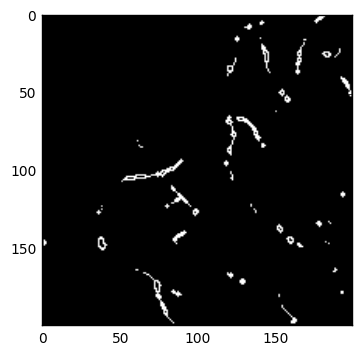

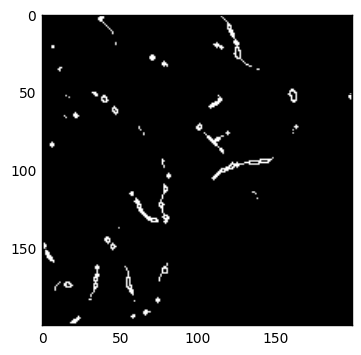

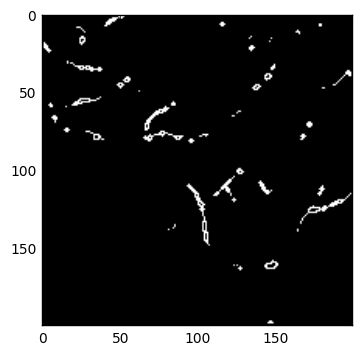

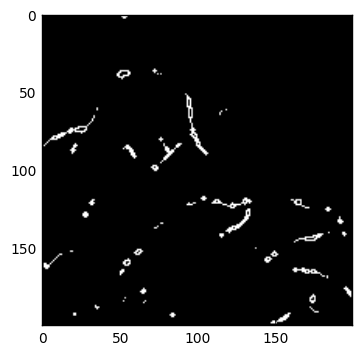

In [98]:
plt.imshow(Volume_Label_dict['y-plus']['volume_label'][6,:,:,50],cmap='gray')
plt.show()
plt.imshow(Volume_Label_dict['y-minus']['volume_label'][6,:,:,50],cmap='gray')
plt.show()
plt.imshow(Volume_Label_dict['x-plus']['volume_label'][6,:,:,50],cmap='gray')
plt.show()
plt.imshow(Volume_Label_dict['x-minus']['volume_label'][6,:,:,50,],cmap='gray')
plt.show()

In [126]:
def X_Y_generator_six_directions(Volume_Label_dict, extra_length):
    '''
        Input: Volume_Label_dict -- dictionary of six (key, value) pair.
                                    'key' name is one of {'y-plus', 'y-minus', 'x-plus',
                                    'x-minus', 'z-plus', 'z-minus'} which denotes the six connections
                                    to which each voxel has the surrounding voxels. (reference: 3D coordinate system)
                                    'value' is a dictionary contains (key,value)=('volume',volume)
                                    and (key,value)=('label',volume_label)
               extra_length -- integer. Determine how large is the patch size, since
                               patch size = [2*extra_length+1, 2*extra_length+1, num_Channel].
        Output: X -- input array of shape=(num_datapoints, 2*extra_length+1, 2*extra_length+1, num_Channel)
                Y -- output array of shape=(num_datapoints, 2)
        This function generates X (input dataset) and Y (output dataset). The size of the input datapoint
        is determined by 'extra_length'.
    '''
    Y=[]
    X=[]
    for direction in Volume_Label_dict.keys():
        Volume = Volume_Label_dict[direction]['volume']
        Volume_Label = Volume_Label_dict[direction]['volume_label']
        one_one, one_zero, zero_one, zero_zero = four_cases_coor(Volume_Label)
        balanced_one_one, balanced_one_zero, balanced_zero_one, balanced_zero_zero = balance_dataset(one_one, one_zero, zero_one, zero_zero)
        label_one_coor = balanced_one_one
        label_zero_coor = balanced_one_zero + balanced_zero_one + balanced_zero_zero
        Y.append(Y_generator(label_one_coor, label_zero_coor))
        new_overallRawVolume = augmented_overallRawVolume(Volume, extra_length)
        coor_list = label_one_coor + label_zero_coor
        X.append(X_generator(coor_list, new_overallRawVolume, 7))
    
    Y = np.concatenate(tuple(Y),axis=0)
    X = np.concatenate(tuple(X),axis=0)
    return X,Y

In [127]:
X,Y = X_Y_generator_six_directions(Volume_Label_dict, 7)

In [128]:
def train_test_division(X_data, Y_data, test_ratio):
    '''
        Input: X_data -- input array of shape=(num_patch, patch_length, patch_width, num_channel).
               Y_data -- output array of shape=(num_patch, 2).
               test_ratio -- float/double number, range=(0,1), represents the ratio between num_test_datapoints and num_total_datapoints. 
        Output: X_train -- training input array.
                Y_train -- training output array.
                X_test -- test input array.
                Y_test -- test output array.
        This function divides raw X(input features),Y(output labels) into training and test X, Y. 
    '''
    num_datapoints = X_data.shape[0]
    test_datapoints_index = np.random.randint(0,num_datapoints,int(num_datapoints*test_ratio)).tolist()
    train_datapoints_index = [index for index in range(num_datapoints) if index not in test_datapoints_index]
    X_test = X_data[test_datapoints_index,:,:,:]
    Y_test = Y_data[test_datapoints_index,:]
    X_train = X_data[train_datapoints_index,:,:,:]
    Y_train = Y_data[train_datapoints_index,:]
    
    return X_train, Y_train, X_test, Y_test

In [ ]:
x_train, y_train, x_test, y_test = train_test_division(X, Y, 0.2)

In [100]:
def get_confusion_matrix_one_hot(model_predictions, true_labels):
    '''
        Inputs: model_predictions -- 2D array of shape=(num_datapoints, num_classes) denotes
                                     model predictions.
                true_labels -- 2D array of shape=(num_datapoints, num_classes)
        Output: confusion_matrix -- 2D array of shape=(num_classes, num_classes)
        This function generates the confusion matrix.
    '''
    assert model_predictions.shape == true_labels.shape
    num_classes = true_labels.shape[1]
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
    predictions = np.argmax(model_predictions,axis=1)
    assert len(predictions)==true_labels.shape[0]

    for actual_class in range(num_classes):
        idx_examples_this_class = true_labels[:,actual_class]==1.0
        prediction_for_this_class = predictions[idx_examples_this_class]
        for predicted_class in range(num_classes):
            count = np.sum(prediction_for_this_class==predicted_class)
            confusion_matrix[actual_class, predicted_class] = count
    assert np.sum(confusion_matrix)==len(true_labels)
    assert np.sum(confusion_matrix)==np.sum(true_labels)
    
    return confusion_matrix

In [101]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [106]:
batch_size = 100
num_classes = 2
epochs = 10

In [107]:
def count_two_class(Y_data):
    '''
        Input: Y_data -- output one-hot array with shape=(num_datapoints, 2)
        Output: None
        This function prints count number of each label in Y_data
    '''
    num_datapoints = Y_data.shape[0]
    num_label_0, num_label_1 = (0,0)
    for i in range(num_datapoints):
        if Y_data[i,0]==1.0:
            num_label_0 += 1
        else:
            num_label_1 += 1
    print('label 0: {0}, {1}; label 1: {2}, {3}.'.format(num_label_0, \
         float(num_label_0)/float(num_datapoints), num_label_1, float(num_label_1)/float(num_datapoints)))

In [108]:
count_two_class(y_train)
count_two_class(y_test)

label 0: 72149, 0.4998545101842871; label 1: 72191, 0.5001454898157129.
label 0: 5043, 0.5043; label 1: 4957, 0.4957.


In [109]:
model = Sequential()

model.add(Conv2D(8, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
print(model.output_shape)
model.add(Conv2D(16, (4, 4),padding='valid'))
model.add(Activation('relu'))
print(model.output_shape)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
print(model.output_shape)
model.add(Conv2D(32, (2, 2), padding='same'))
model.add(Activation('relu'))
print(model.output_shape)
model.add(Conv2D(32, (3, 3), padding='valid'))
model.add(Activation('relu'))
print(model.output_shape)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
print(model.output_shape)
model.add(Flatten())
print(model.output_shape)
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
print(model.output_shape)
model.summary()

(None, 15, 15, 8)
(None, 12, 12, 16)
(None, 6, 6, 16)
(None, 6, 6, 32)
(None, 4, 4, 32)
(None, 2, 2, 32)
(None, 128)
(None, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 15, 15, 8)         296       
_________________________________________________________________
activation_7 (Activation)    (None, 15, 15, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 16)        2064      
_________________________________________________________________
activation_8 (Activation)    (None, 12, 12, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 6, 16)          0         
_______________

In [110]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 144340 samples, validate on 10000 samples
Epoch 1/10
144340/144340 [==============================] - 77s - loss: 0.3622 - acc: 0.8303 - val_loss: 0.1687 - val_acc: 0.9378
Epoch 2/10
144340/144340 [==============================] - 77s - loss: 0.1688 - acc: 0.9349 - val_loss: 0.0848 - val_acc: 0.9698
Epoch 3/10
144340/144340 [==============================] - 79s - loss: 0.1216 - acc: 0.9571 - val_loss: 0.0755 - val_acc: 0.9749
Epoch 4/10
144340/144340 [==============================] - 82s - loss: 0.1012 - acc: 0.9658 - val_loss: 0.0643 - val_acc: 0.9783
Epoch 5/10
144340/144340 [==============================] - 74s - loss: 0.0917 - acc: 0.9699 - val_loss: 0.0592 - val_acc: 0.9812
Epoch 6/10
144340/144340 [==============================] - 77s - loss: 0.0870 - acc: 0.9725 - val_loss: 0.0605 - val_acc: 0.9811
Epoch 7/10
144340/144340 [==============================] - 82s - loss: 0.0818 - acc: 0.9749 - val_loss: 0.0613 - val_acc: 0.9821
Epoch 8/10
144340/144340 [=============

In [111]:
model_predictions = model.predict(x_test, batch_size=1, verbose=1)
get_confusion_matrix_one_hot(model_predictions, y_test)

 9976/10000 [============================>.] - ETA: 0s

array([[4992,   51],
       [ 144, 4813]], dtype=int32)

In [112]:
overallRawVolume = sio.loadmat('./sims_9cells_4ch_0bn_0.1pn_1e-06pd_1.0ef_raw/overallRawVolume.mat')['overallRawVolume'].astype(np.float) #shape=(200, 200, 100, 4), value range=(0,1)
volumeLabels = sio.loadmat('./sims_9cells_4ch_0bn_0.1pn_1e-06pd_1.0ef_raw/volumeLabels.mat')['volumeLabels']#shape=(1, 9), each entry is an array with shape=(200, 200, 100)

In [113]:
new_VolumeLabels = process_volumeLabels(volumeLabels) #shape=(9,200,200,100)

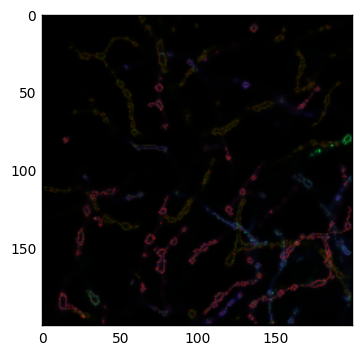

In [114]:
image3 = overallRawVolume[:,:,50,:3]
plt.imshow(image3,cmap='gray')
plt.show()

In [115]:
one_one, one_zero, zero_one, zero_zero = four_cases_data(new_VolumeLabels)
print(len(one_one), len(one_zero), len(zero_one), len(zero_zero))

68812 56650 55766 3798772


In [116]:
balanced_one_one, balanced_one_zero, balanced_zero_one, balanced_zero_zero = balance_dataset(one_one, one_zero, zero_one, zero_zero)
print(len(balanced_one_one), len(balanced_one_zero), len(balanced_zero_one), len(balanced_zero_zero))

68812 22937 22937 22938


In [117]:
Y = build_Y(balanced_one_one, balanced_one_zero, balanced_zero_one, balanced_zero_zero)

In [118]:
new_overallRawVolume = augmented_overallRawVolume(overallRawVolume, 7)

In [119]:
X = build_X(balanced_one_one, balanced_one_zero, balanced_zero_one, balanced_zero_zero, new_overallRawVolume, 7)

In [120]:
score = model.evaluate(X, Y, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

137440/137624 [============================>.] - ETA: 0sTest loss: 0.173933028791
Test accuracy: 0.947567284776


In [121]:
model_predictions = model.predict(X, batch_size=1, verbose=1)
get_confusion_matrix_one_hot(model_predictions, Y)

137615/137624 [============================>.] - ETA: 0s

array([[67413,  1399],
       [ 5817, 62995]], dtype=int32)

In [122]:
model.save('neuron_classifier_v3.h5')

In [ ]:
model = load_model('neuron_classifier_v3.h5')